In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

In [2]:
data = np.load("modelnet10.npz", allow_pickle=True)
train_voxel = data["train_voxel"] # Training 3D voxel samples
test_voxel = data["test_voxel"] # Test 3D voxel samples
train_labels = data["train_labels"] # Training labels (integers from 0 to 9)
test_labels = data["test_labels"] # Test labels (integers from 0 to 9)
class_map = data["class_map"] # Dictionary mapping the labels to their class names.

In [ ]:
# Print all class names from ndarray dictionary
for i in class_map.item():
    print(i, class_map.item()[i])

In [16]:
# Plot a 3D voxel sample

# Plot a 3D voxel sample


def plot_voxel(voxel, threshold=0.5):
    binary_voxel = voxel > threshold
    ax = plt.figure().add_subplot(projection='3d')
    ax.voxels(voxel)
    plt.show()

# test plot_voxel
# plot_voxel(train_voxel[0])

# ax = plt.figure().add_subplot(projection='3d')
# #add index to model
# index = 0
# ax.voxels(train_voxel[index])
# ax.set_title(class_map.item()[train_labels[index]])
# plt.show()

In [4]:
class Generator(torch.nn.Module):
    def __init__(self, in_channels=512, out_dim=64, out_channels=1, noise_dim=200, activation="sigmoid"):
        super(Generator, self).__init__()
        self.in_channels = in_channels
        self.out_dim = out_dim
        self.in_dim = int(out_dim / 16)
        conv1_out_channels = int(self.in_channels / 2.0)
        conv2_out_channels = int(conv1_out_channels / 2)
        conv3_out_channels = int(conv2_out_channels / 2)

        self.linear = torch.nn.Linear(noise_dim, in_channels * self.in_dim * self.in_dim * self.in_dim)

        self.conv1 = nn.Sequential(
            nn.ConvTranspose3d(
                in_channels=in_channels, out_channels=conv1_out_channels, kernel_size=(4, 4, 4),
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(conv1_out_channels),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose3d(
                in_channels=conv1_out_channels, out_channels=conv2_out_channels, kernel_size=(4, 4, 4),
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(conv2_out_channels),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose3d(
                in_channels=conv2_out_channels, out_channels=conv3_out_channels, kernel_size=(4, 4, 4),
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(conv3_out_channels),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.ConvTranspose3d(
                in_channels=conv3_out_channels, out_channels=out_channels, kernel_size=(4, 4, 4),
                stride=2, padding=1, bias=False
            )
        )
        if activation == "sigmoid":
            self.out = torch.nn.Sigmoid()
        else:
            self.out = torch.nn.Tanh()

    def project(self, x):
        """
        projects and reshapes latent vector to starting volume
        :param x: latent vector
        :return: starting volume
        """
        return x.view(-1, self.in_channels, self.in_dim, self.in_dim, self.in_dim)

    def forward(self, x):
        x = self.linear(x)
        x = self.project(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return self.out(x)

In [5]:
class Discriminator(torch.nn.Module):
    def __init__(self, in_channels=1, dim=64, out_conv_channels=512):
        super(Discriminator, self).__init__()
        conv1_channels = int(out_conv_channels / 8)
        conv2_channels = int(out_conv_channels / 4)
        conv3_channels = int(out_conv_channels / 2)
        self.out_conv_channels = out_conv_channels
        self.out_dim = int(dim / 16)

        self.conv1 = nn.Sequential(
            nn.Conv3d(
                in_channels=in_channels, out_channels=conv1_channels, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(conv1_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv3d(
                in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(conv2_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv3d(
                in_channels=conv2_channels, out_channels=conv3_channels, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(conv3_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv3d(
                in_channels=conv3_channels, out_channels=out_conv_channels, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(out_conv_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.out = nn.Sequential(
            nn.Linear(out_conv_channels * self.out_dim * self.out_dim * self.out_dim, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Flatten and apply linear + sigmoid
        x = x.view(-1, self.out_conv_channels * self.out_dim * self.out_dim * self.out_dim)
        x = self.out(x)
        return x

In [14]:
class GAN3D(pl.LightningModule):
    def __init__(self, noise_dim=200, g_lr=0.0025, d_lr=1e-5, b1=0.5, b2=0.999):
        super(GAN3D, self).__init__()
        self.noise_dim = noise_dim
        self.generator = Generator(noise_dim=noise_dim)
        self.discriminator = Discriminator()
        self.g_lr = g_lr
        self.d_lr = d_lr
        self.b1 = b1
        self.b2 = b2
        self.loss = nn.BCELoss()
        self.automatic_optimization = False
        self.validation_z = torch.randn(8, self.noise_dim)
        self.last_acc = False

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return self.loss(y_hat, y)

    def training_step(self, batch, batch_idx):
        imgs, _ = batch
        imgs = imgs.to(self.device)
        opt_g, opt_d = self.optimizers()

        # Adversarial ground truths
        valid = torch.ones(imgs.size(0), 1).to(self.device)
        fake = torch.zeros(imgs.size(0), 1).to(self.device)

        # Train Generator
        opt_g.zero_grad()
        z = torch.randn(imgs.shape[0], self.noise_dim).to(self.device)
        generated_imgs = self(z)
        g_loss = self.adversarial_loss(self.discriminator(generated_imgs), valid)
        g_loss.backward()
        opt_g.step()

        # Train Discriminator
        threshold = 0.5
        d_acc = self.discriminator(imgs)
        elements_over_threshold = lambda tensor, threshold=0.5: (tensor > threshold).sum().item()
        self.log('d_acc', elements_over_threshold(d_acc, threshold))

        # Only update if accuracy for last batch was less than 0.8
        
        opt_d.zero_grad()
        z = torch.randn(imgs.shape[0], self.noise_dim).to(self.device)
        generated_imgs = self(z)
        real_loss = self.adversarial_loss(self.discriminator(imgs), valid)
        fake_loss = self.adversarial_loss(self.discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        if self.last_acc:
            d_loss.backward()
            opt_d.step()

        if elements_over_threshold(d_acc, threshold) < 0.8 * d_acc.shape[0]:
            self.last_acc = True
        else:
            self.last_acc = False

        # Log in tensorboard
        self.log('g_loss', g_loss)
        self.log('d_loss', d_loss)
        loss = (g_loss + d_loss) / 2
        self.log('loss', loss)

    def configure_optimizers(self):
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=self.g_lr, betas=(self.b1, self.b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=self.d_lr, betas=(self.b1, self.b2))
        return [opt_g, opt_d], []
    
    def on_train_epoch_end(self):
        # Plot generated 3D voxel samples
        # self.eval()
        generated_imgs = self(self.validation_z.to(self.device))
        plot_voxel(generated_imgs[0].detach().cpu().numpy().squeeze(), threshold=0.5)

In [8]:
# Dataset
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.float()),  # Convert tensor to float type
    transforms.Lambda(lambda x: x.unsqueeze(0) if len(x.shape) == 3 else x),  # Add channel dimension
    transforms.Normalize((0.5,), (0.5,))
])


class VoxelDataset(Dataset):
    def __init__(self, data, label,transform=None):
        self.data = data
        self.label = label
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        voxel = self.data[index]
        label = self.label[index]
        if self.transform:
            voxel = self.transform(voxel)
        
        # Print the dimensions of the voxel
        # print(f"Voxel at index {index} has dimensions: {voxel.shape}")
        
        return voxel, label

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 17.6 M
1 | discriminator | Discriminator | 11.0 M
2 | loss          | BCELoss       | 0     
------------------------------------------------
28.7 M    Trainable params
0         Non-trainable params
28.7 M    Total params
114.601   Total estimated model params size (MB)


Epoch 0: 100%|██████████| 40/40 [00:49<00:00,  1.24s/it, v_num=9]

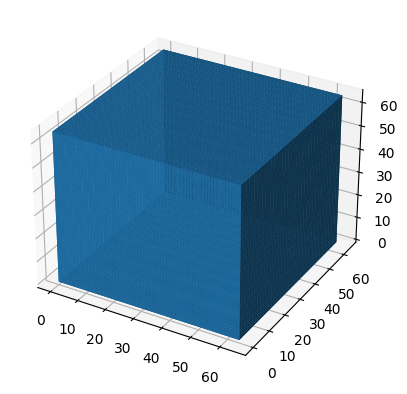

Epoch 1:  20%|██        | 8/40 [00:09<00:38,  1.20s/it, v_num=9] 

In [17]:
# Empty the cache
torch.cuda.empty_cache()

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset
train_dataset = VoxelDataset(train_voxel, train_labels,transform=transform)
# test_dataset = VoxelDataset(test_voxel, test_labels,transform=transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Set logger
tb_logger = TensorBoardLogger('logs/')

# Initialize the GAN
model = GAN3D()
model = model.to(device)

# Initialize the Trainer
trainer = pl.Trainer(max_epochs=100, accelerator="gpu", logger=tb_logger, log_every_n_steps=20)

# Train the model
trainer.fit(model, train_loader)

# Save model
torch.save(model.state_dict(), "3d_gan.pt")